In [1]:
! pip install btester requests tqdm yfinance QuantStats

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import yfinance as yf
import pandas as pd
import requests

start = '2006-01-01'
end = '2024-01-01'

assets = 'nasdaq100'
benchmark = 'NQ=F'

ldf = pd.read_html(requests.get(f'https://www.slickcharts.com/{assets}', headers={'User-agent': 'Mozilla/5.0'}).text)
symbols = [x.replace('.','-') for x in ldf[0]['Symbol'] if isinstance(x, str)]
downloads = yf.download([*symbols, benchmark], start, end, group_by='ticker')

data = downloads[symbols]
benchmark = downloads[benchmark]['Close']

[*********************100%%**********************]  102 of 102 completed


In [4]:
from btester import Strategy

def UpBreakout(ser: pd.Series, period: int):
    return (ser.rolling(period).max().diff() > 0).values

def DownBreakout(ser: pd.Series, period: int):
    return (ser.rolling(period).min().diff() < 0).values

class BreakoutStrategy(Strategy):
    buy_at_once_size = .05 # 5%

    def init(self, buy_period: int, sell_period: int):
        self.buy_signal = {}
        self.sell_signal = {}

        for symbol in self.symbols:
            self.buy_signal[symbol] = UpBreakout(self.data[(symbol,'Close')], buy_period)
            self.sell_signal[symbol] = DownBreakout(self.data[(symbol,'Close')], sell_period)

    def next(self, i, record):
        for symbol in self.symbols:
            if self.buy_signal[symbol][i-1]:
                self.open(symbol=symbol, price=record[(symbol,'Open')], size=self.positionSize(record[(symbol,'Open')]))

        for position in self.open_positions[:]:
            if self.sell_signal[position.symbol][i-1]:
                self.close(position=position, price=record[(position.symbol,'Open')])

    def positionSize(self, price: float):
        return round((self.cash + self.assets_value) / price * self.buy_at_once_size) if price > 0 else 0

In [5]:
from btester import Backtest
backtest = Backtest(BreakoutStrategy, data, commission=.001, cash=1e6)

In [6]:
import pandas as pd
import quantstats as qs
from itertools import product
from tqdm.contrib.concurrent import process_map

parameters = ['Buy period','Sell period']
values = [[5, 10, 20, 50, 75, 100, 150, 200], [5, 10, 20, 50, 75, 100, 150, 200]]

def run(v):
    result = backtest.run(*v)
    returns = result.returns
    return [*v, returns.iloc[0], returns.iloc[-1], qs.stats.max_drawdown(returns) * 100, qs.stats.cagr(returns) * 100, qs.stats.sharpe(returns)]

optimization_results = process_map(run, list(product(*values)))
optimization_results = pd.DataFrame(optimization_results, columns=[*parameters,'Initial Capital','Cumulative Return','Max Drawdown (%)','CAGR (%)','Sharpe Ratio'])
optimization_results.set_index([*parameters], inplace=True)

100%|██████████| 64/64 [00:06<00:00, 10.26it/s]


In [7]:
optimization_results_sorted = optimization_results.sort_values('Sharpe Ratio', ascending=False)
optimization_results_sorted

Initial Capital  Cumulative Return  Max Drawdown (%)  \
Buy period Sell period                                                         
10         100             1.000883e+06       6.849385e+07        -47.480370   
20         50              1.000221e+06       4.597639e+07        -43.124529   
           75              1.000221e+06       5.407552e+07        -43.625478   
50         100             1.000000e+06       6.569414e+07        -44.139855   
10         150             1.000883e+06       5.807045e+07        -53.028058   
...                                 ...                ...               ...   
200        10              1.000000e+06       1.676885e+06        -41.685957   
150        10              1.000000e+06       1.487367e+06        -50.042386   
100        5               1.000000e+06       1.388974e+06        -50.082753   
200        5               1.000000e+06       1.108174e+06        -49.047422   
150        5               1.000000e+06       1.064430e+06        -55.835647   

                         CAGR (%)  Sharpe Ratio  
Buy period Sell period                           
10         100          26.466313      1.161164  
20         50           23.700592      1.083546  
           75           24.820853      1.080399  
50         100          26.179579      1.080051  
10         150          25.311554      1.072680  
...                           ...           ...  
200        10            2.913963      0.261064  
150        10            2.230443      0.217397  
100        5             1.842408      0.199631  
200        5             0.572348      0.109154  
150        5             0.347541      0.094610  

[64 rows x 5 columns]

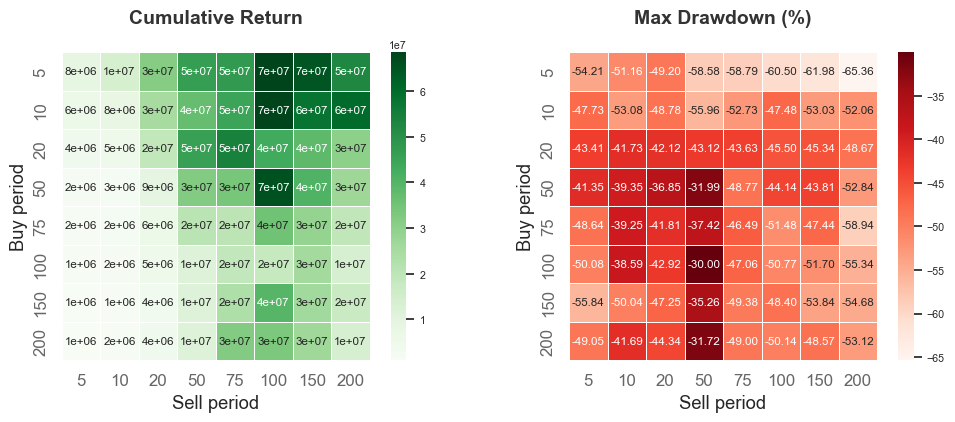

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].set_title('Cumulative Return\n', fontsize=14, fontweight='bold')
ax[1].set_title('Max Drawdown (%)\n', fontsize=14, fontweight='bold')

reshape = lambda d: pd.DataFrame(d.values.reshape(len(d.index.levels[0]), len(d.index.levels[1])), d.index.levels[0], d.index.levels[1])

sns.set(font_scale=.7)
sns.heatmap(reshape(optimization_results['Cumulative Return']), ax=ax[0], annot=True, fmt='.0g', linewidth=.5, square=True, cmap='Greens')
sns.heatmap(reshape(optimization_results['Max Drawdown (%)']), ax=ax[1], annot=True, fmt='.2f', linewidth=.5, square=True, cmap='Reds')

plt.show()

In [9]:
best_params = optimization_results_sorted.index[0]
best_params

(10, 100)

In [10]:
result = backtest.run(*best_params)

In [11]:
import quantstats as qs
qs.reports.metrics(result.returns, benchmark)

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2006-01-03  2006-01-03
End Period          2023-12-29  2023-12-29
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   6,743.34%   905.52%
CAGR﹪              26.47%      13.68%

Sharpe              1.16        0.69
Prob. Sharpe Ratio  100.0%      99.82%
Sortino             1.68        0.97
Sortino/√2          1.19        0.69
Omega               1.22        1.22

Max Drawdown        -47.48%     -53.85%
Longest DD Days     871         1161

Gain/Pain Ratio     0.22        0.14
Gain/Pain (1M)      1.6         0.83

Payoff Ratio        0.93        0.86
Profit Factor       1.22        1.14
Common Sense Ratio  1.2         1.04
CPC Index           0.64        0.54
Tail Ratio          0.99        0.92
Outlier Win Ratio   3.69        4.1
Outlier Loss Ratio  3.8         4.02

MTD                 6.6%        6.49%
3M                  14.85%      14

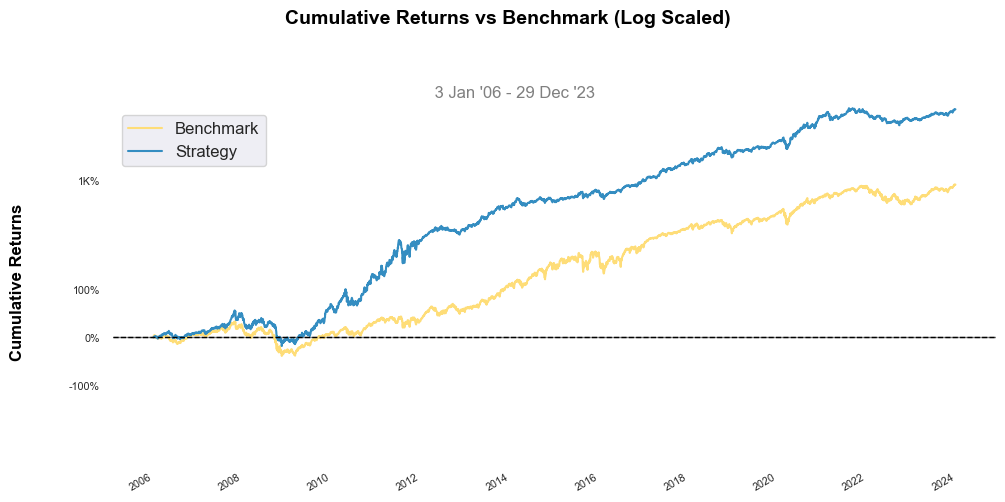

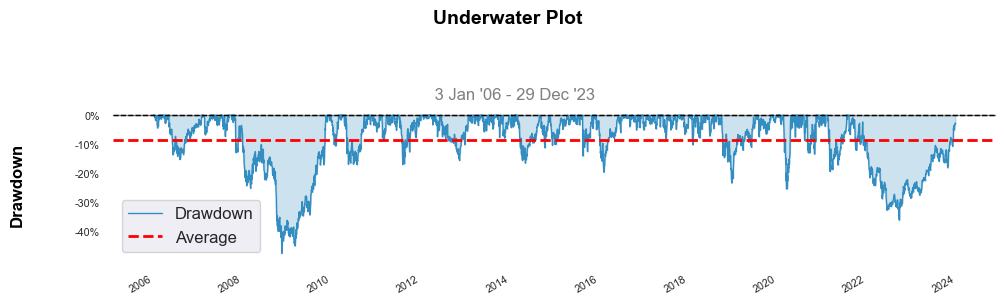

In [12]:
qs.plots.log_returns(result.returns, benchmark, fontname='sans-serif')
qs.plots.drawdown(result.returns, figsize=(10,3), fontname='sans-serif')

In [13]:
trades = pd.DataFrame(result.trades)
trades

,symbol,open_date,close_date,open_price,close_price,position_size,profit_loss,change_pct,trade_commission,cumulative_return
0,MAR,2006-01-03,2007-05-10,31.285149,41.576805,1598,16446.067078,32.896300,116.433402,1.016330e+06
1,DXCM,2006-02-01,2007-06-04,4.750000,1.620000,10669,-33393.969949,-65.894737,67.961530,9.828677e+05
2,ROST,2006-01-03,2007-06-07,7.187500,7.812500,6954,4346.250000,8.695652,104.310000,9.871096e+05
3,AMD,2006-02-01,2007-08-08,41.299999,12.820000,1228,-34973.439438,-68.958838,66.459359,9.520697e+05
4,CDNS,2006-02-01,2007-08-08,17.420000,20.379999,2910,8613.597336,16.991958,109.997998,9.605733e+05
...,...,...,...,...,...,...,...,...,...,...
330,ORLY,2022-06-24,2023-10-24,630.090027,879.619995,3824,954202.598633,39.602272,5773.131124,4.823422e+07
331,ORLY,2022-07-14,2023-10-24,661.969971,879.619995,3660,796599.089355,32.879139,5642.219275,4.902518e+07
332,AAPL,2023-05-22,2023-10-27,173.979996,166.910004,16467,-116421.559341,-4.063681,5613.435620,4.890314e+07
333,AAPL,2023-05-31,2023-10-27,177.330002,166.910004,16359,-170460.750046,-5.876049,5631.422250,4.872705e+07


In [14]:
open_positions = pd.DataFrame(result.open_positions)
open_positions

,symbol,open_date,last_date,open_price,last_price,position_size,profit_loss,change_pct,current_value
0,VRTX,2022-01-31,2023-12-29,240.869995,406.890015,11689,1.940608e+06,68.925156,4.756137e+06
1,VRTX,2022-06-24,2023-12-29,286.260010,406.890015,8419,1.015584e+06,42.140013,3.425607e+06
2,VRSK,2022-06-24,2023-12-29,171.479996,238.860001,14050,9.466891e+05,39.293216,3.355983e+06
3,MAR,2022-07-14,2023-12-29,137.960007,225.509995,17562,1.537553e+06,63.460411,3.960407e+06
4,NVDA,2022-12-09,2023-12-29,171.600006,495.220001,15462,5.003812e+06,188.589734,7.657092e+06
5,INTC,2023-03-13,2023-12-29,26.740000,50.250000,95681,2.249460e+06,87.920720,4.807970e+06
6,VRTX,2023-03-14,2023-12-29,293.809998,406.890015,8711,9.850400e+05,38.487464,3.544419e+06
7,MSFT,2023-03-17,2023-12-29,278.260010,376.040009,9385,9.176653e+05,35.139796,3.529135e+06
8,MSFT,2023-04-27,2023-12-29,295.970001,376.040009,9234,7.393664e+05,27.053420,3.472353e+06
9,AVGO,2023-05-22,2023-12-29,681.400024,1116.250000,4204,1.828109e+06,63.817135,4.692715e+06
